<a href="https://colab.research.google.com/github/MathiasMoelgaard/Capstone/blob/main/AudioNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#Install audio libraries
#Add any libraries that will need to be installed here
!sudo apt install libsndfile1
!pip install librosa
!pip install noisereduce

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2build1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [1]:
#Load libraries
#Add all libraries needed here
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile
from google.colab import drive
import noisereduce as nr
from IPython.display import Audio
import skimage.measure
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This below Section is dedicated for loading data

In [2]:
#Load data
#please add your drive path to the "folderMaps" and change "data_folder" accodingly
folderMaps = {"Mathias":"drive/MyDrive/Fall23/Capstone/Team7_Capstone_Project/DemoAudioFiles/",
              "Yuan":"/content/drive/MyDrive/Team7_Capstone_Project/DemoAudioFiles/",
              "Yash": "/content/drive/MyDrive/Team7_Capstone_Project/DemoAudioFiles/",
}
data_folder = folderMaps["Mathias"]
!ls $data_folder

'2023-09-19 ch1 call stats.xlsx'  '2023-09-19 ch1 detections.mat'  '2023-09-19 ch1.wav'   ch1.log


In [3]:
#Simple loading of audio data
y, sr = librosa.load(data_folder + '2023-09-19 ch1.wav', sr=250000)

#ydub, sr = librosa.load(data_folder + '2023-09-19 ch1.wav', sr=250000) #slight delay


#ydub, sr = librosa.load(data_folder + '2023-09-19 ch1.wav', sr=250000) #slight delay with disturd with some known random function



#fig, ax = plt.subplots(nrows=2, sharex=True)
#librosa.display.waveshow(y[8950000:9200000], sr=sr, ax=ax[0], label = "Mouse X") #1 second interval
#librosa.display.waveshow(y[6360000:6610000], sr=sr, ax=ax[0], color = "red", label = "Mouse Y", alpha = .3) #1 second interval
#ax[0].set(title='Example Mouse Pitch Overlaps Microphone #1')
#librosa.display.waveshow(y[8920000:9180000], sr=sr, ax=ax[1], label = "Mouse X") #1 second interval
#librosa.display.waveshow(y[6370000:6620000], sr=sr, ax=ax[1], color = "red", label = "Mouse Y", alpha = .3) #1 second interval
#ax[1].set(title='Example Mouse Pitch Overlaps Microphone #2')
#fig.tight_layout(pad=2.0)
#plt.show()

In [4]:
#Get 6 second slices
#Noises seen between 6-12 sec,
minuteSize = 250000*6
start, end = minuteSize*10, minuteSize*11

This below Section is dedicated to data cleaning and preparation (Complete by Thursday October 26th)

The following section is Mathias work for preprocessing

In [5]:
#Code following the guide here: https://librosa.org/doc/latest/auto_examples/plot_vocal_separation.html
ySmall = y[start:end]
#ySmall = nr.reduce_noise(y=ySmall, sr=250000)
frequency_slice, phase = librosa.magphase(librosa.stft(ySmall))
print("Current sample size: {}".format(frequency_slice.shape))

Current sample size: (1025, 2930)


In [ ]:
#Display random spectogram RAW
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(frequency_slice, ref=np.max), x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

Current sample size: (205, 1465)
Current sample size: (1025, 1465)
Current sample size: (1025, 2930)


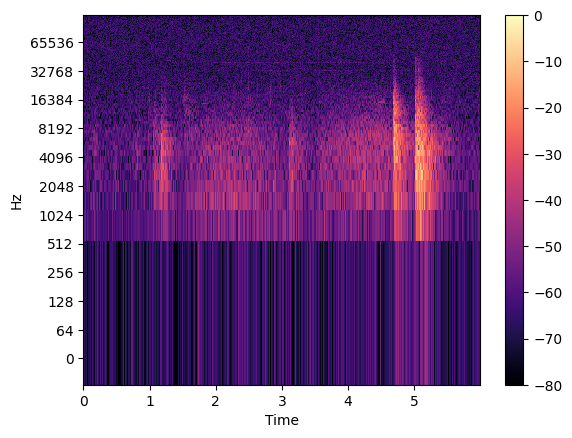

In [ ]:
#Try reduce image
reducedFrequency = skimage.measure.block_reduce(frequency_slice, (5,2), np.min)
print("Current sample size: {}".format(reducedFrequency.shape))
#Resize frequency
resizedFrequency = np.repeat(reducedFrequency, 5,axis=0)
print("Current sample size: {}".format(resizedFrequency.shape))
resizedFrequency = np.repeat(resizedFrequency, 2,axis=1)
print("Current sample size: {}".format(resizedFrequency.shape))

#Display resized spectogram RAW
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(resizedFrequency, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

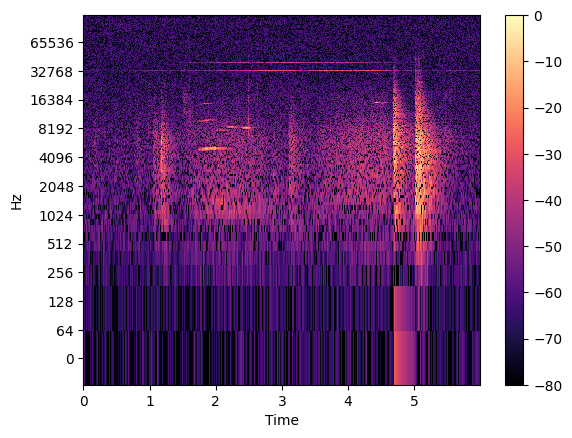

In [ ]:
removedNegative = frequency_slice-resizedFrequency
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(removedNegative, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

In [ ]:
frequencyToDecompose = removedNegative

S_filter = librosa.decompose.nn_filter(frequencyToDecompose,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(1, sr=sr)))
S_filter = np.minimum(frequencyToDecompose, S_filter)

In [ ]:
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (frequencyToDecompose - S_filter),
                               power=power)

mask_v = librosa.util.softmask(frequencyToDecompose - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * frequencyToDecompose
S_background = mask_i * frequencyToDecompose

Current sample size: (1025, 1465)
Current sample size: (1025, 1465)
Current sample size: (1025, 2930)


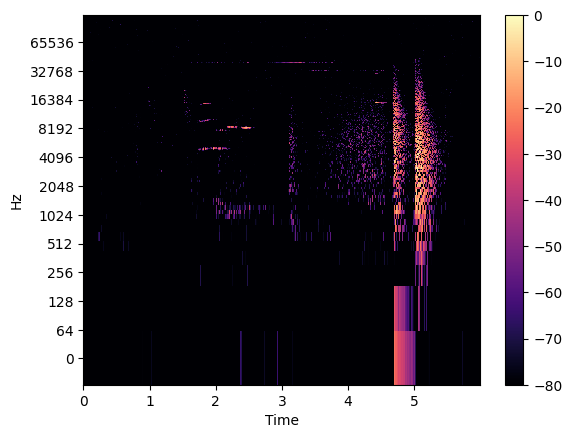

In [ ]:
#Try reduce image again
reducedFrequency = skimage.measure.block_reduce(S_foreground, (1,2), np.min)
print("Current sample size: {}".format(reducedFrequency.shape))
#Resize frequency
resizedFrequency = np.repeat(reducedFrequency, 1,axis=0)
print("Current sample size: {}".format(resizedFrequency.shape))
resizedFrequency = np.repeat(resizedFrequency, 2,axis=1)
print("Current sample size: {}".format(resizedFrequency.shape))

#Display resized spectogram RAW
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(resizedFrequency, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

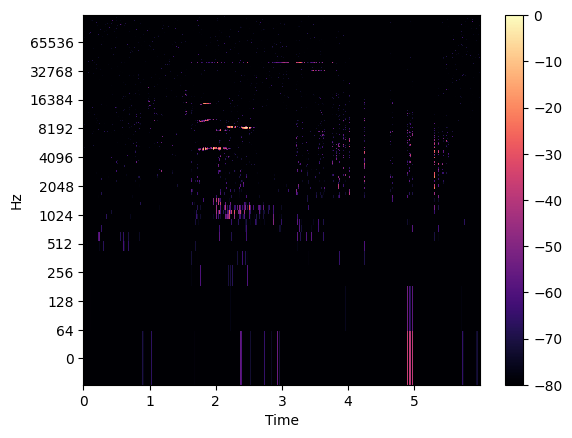

In [ ]:
noiseMask = np.count_nonzero(resizedFrequency, axis = 0) > 320
resizedFrequency[:,noiseMask] = 0.0

#Display resized spectogram RAW
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(resizedFrequency, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

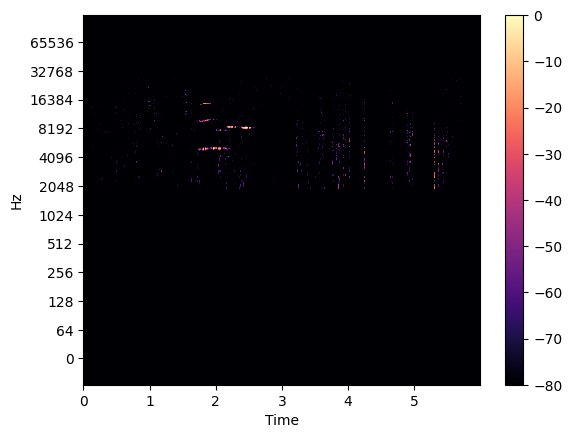

In [ ]:
resizedFrequency[0:16] = 0
resizedFrequency[-800:] = 0
#Display random spectogram initial cleaning
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(resizedFrequency, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

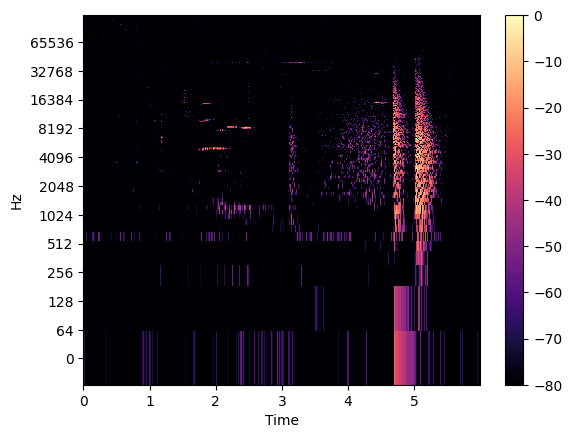

In [ ]:
#Display random spectogram initial cleaning
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_foreground, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

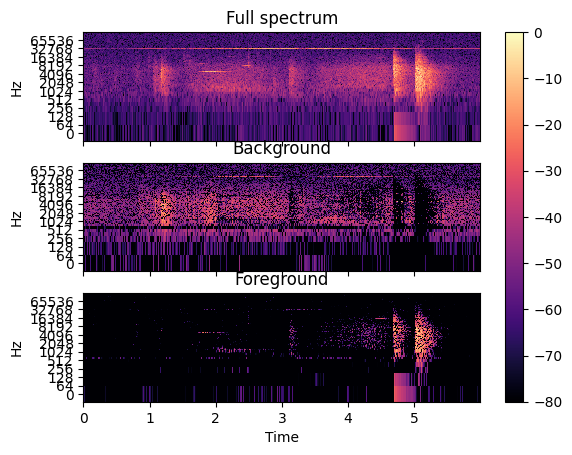

In [ ]:
# sphinx_gallery_thumbnail_number = 2

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(frequency_slice, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].set(title='Full spectrum')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_background, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title='Background')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_foreground, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[2])
ax[2].set(title='Foreground')
fig.colorbar(img, ax=ax)

-117.317635

In [ ]:
#Develop intense noise filter
db_sample = librosa.amplitude_to_db(S_foreground, ref=np.max)
overallMeanNoise = np.mean(db_sample)
minValue = np.mean(db_sample[0:100] + db_sample[-100:], axis=0).min()
highMask = np.mean(db_sample[0:100] + db_sample[-100:], axis=0) != minValue
db_sample *= highMask
db_sample[db_sample == 0] = overallMeanNoise

#Display random spectogram
fig, ax = plt.subplots()
img = librosa.display.specshow(db_sample,
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

frequency_slice2 = librosa.db_to_amplitude(db_sample, ref=1.0)

Error in callback <function flush_figures at 0x7d5d75b04c10> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
#Before audio
from IPython.display import Audio
import noisereduce as nr
Audio(data=y[start:end], rate=sr)

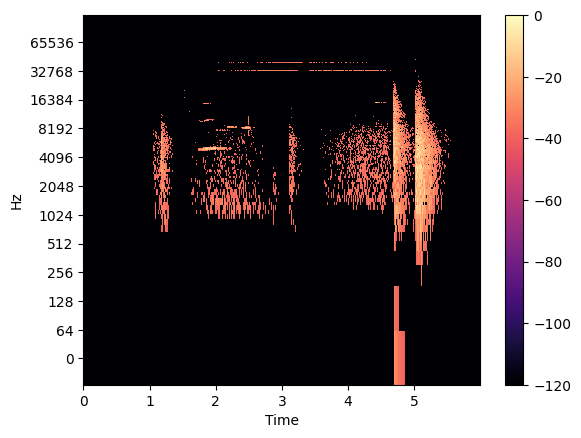

In [ ]:
#Develop low noise filter
db_sample = librosa.amplitude_to_db(frequency_slice, ref=np.max)
db_sample[db_sample < -40] = -120

#Display random spectogram
fig, ax = plt.subplots()
img = librosa.display.specshow(db_sample,
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

frequency_slice2 = librosa.db_to_amplitude(db_sample, ref=1.0)

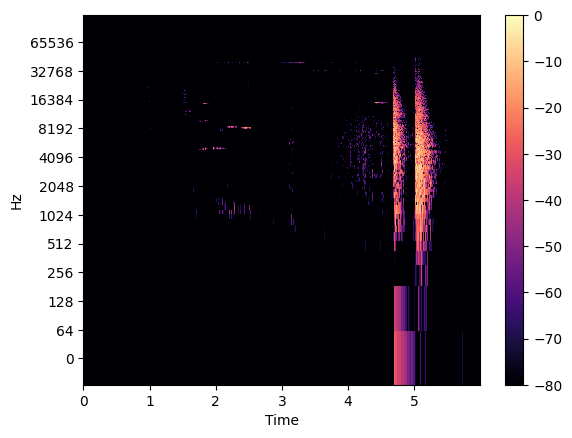

In [ ]:
#Cleaned data
#Display random spectogram
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_foreground, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

In [ ]:
#Yash work

In [ ]:
import noisereduce as nr

In [ ]:
y, sr = librosa.load(data_folder + '2023-09-19 ch1.wav', sr=250000)



In [ ]:

minuteSize = 25000*60
start, end = minuteSize, minuteSize*2

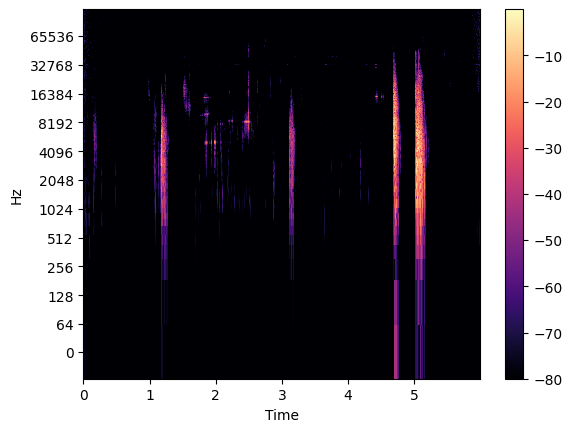

In [ ]:
reduced_noise = nr.reduce_noise(y=y[start:end],  sr=25000)
reduced_noise
reduced_slice, phase = librosa.magphase(librosa.stft(reduced_noise))

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(reduced_slice, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

In [ ]:



## Find peaks in signals
import scipy

scipy.signal.find_peaks(y[start:end], height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)

NameError: ignored

In [ ]:
## need to get timestamps of start and end of noise signals
import itertools

from .utils import db_to_float


def detect_silence(audio_segment, min_silence_len=1000, silence_thresh=-16, seek_step=1):
    """
    Returns a list of all silent sections [start, end] in milliseconds of audio_segment.
    Inverse of detect_nonsilent()

    audio_segment - the segment to find silence in
    min_silence_len - the minimum length for any silent section
    silence_thresh - the upper bound for how quiet is silent in dFBS
    seek_step - step size for interating over the segment in ms
    """
    seg_len = len(audio_segment)

    # you can't have a silent portion of a sound that is longer than the sound
    if seg_len < min_silence_len:
        return []

    # convert silence threshold to a float value (so we can compare it to rms)
    silence_thresh = db_to_float(silence_thresh) * audio_segment.max_possible_amplitude

    # find silence and add start and end indicies to the to_cut list
    silence_starts = []

    # check successive (1 sec by default) chunk of sound for silence
    # try a chunk at every "seek step" (or every chunk for a seek step == 1)
    last_slice_start = seg_len - min_silence_len
    slice_starts = range(0, last_slice_start + 1, seek_step)

    # guarantee last_slice_start is included in the range
    # to make sure the last portion of the audio is searched
    if last_slice_start % seek_step:
        slice_starts = itertools.chain(slice_starts, [last_slice_start])

    for i in slice_starts:
        audio_slice = audio_segment[i:i + min_silence_len]
        if audio_slice.rms <= silence_thresh:
            silence_starts.append(i)

    # short circuit when there is no silence
    if not silence_starts:
        return []

    # combine the silence we detected into ranges (start ms - end ms)
    silent_ranges = []

    prev_i = silence_starts.pop(0)
    current_range_start = prev_i

    for silence_start_i in silence_starts:
        continuous = (silence_start_i == prev_i + seek_step)

        # sometimes two small blips are enough for one particular slice to be
        # non-silent, despite the silence all running together. Just combine
        # the two overlapping silent ranges.
        silence_has_gap = silence_start_i > (prev_i + min_silence_len)

        if not continuous and silence_has_gap:
            silent_ranges.append([current_range_start,
                                  prev_i + min_silence_len])
            current_range_start = silence_start_i
        prev_i = silence_start_i

    silent_ranges.append([current_range_start,
                          prev_i + min_silence_len])

    return silent_ranges


def detect_nonsilent(audio_segment, min_silence_len=1000, silence_thresh=-16, seek_step=1):
    """
    Returns a list of all nonsilent sections [start, end] in milliseconds of audio_segment.
    Inverse of detect_silent()

    audio_segment - the segment to find silence in
    min_silence_len - the minimum length for any silent section
    silence_thresh - the upper bound for how quiet is silent in dFBS
    seek_step - step size for interating over the segment in ms
    """
    silent_ranges = detect_silence(audio_segment, min_silence_len, silence_thresh, seek_step)
    len_seg = len(audio_segment)

    # if there is no silence, the whole thing is nonsilent
    if not silent_ranges:
        return [[0, len_seg]]

    # short circuit when the whole audio segment is silent
    if silent_ranges[0][0] == 0 and silent_ranges[0][1] == len_seg:
        return []

    prev_end_i = 0
    nonsilent_ranges = []
    for start_i, end_i in silent_ranges:
        nonsilent_ranges.append([prev_end_i, start_i])
        prev_end_i = end_i

    if end_i != len_seg:
        nonsilent_ranges.append([prev_end_i, len_seg])

    if nonsilent_ranges[0] == [0, 0]:
        nonsilent_ranges.pop(0)

    return nonsilent_ranges


In [ ]:
def split_on_silence(audio_segment, min_silence_len=1000, silence_thresh=-16, keep_silence=100,
                     seek_step=1):
    """
    Returns list of audio segments from splitting audio_segment on silent sections

    audio_segment - original pydub.AudioSegment() object

    min_silence_len - (in ms) minimum length of a silence to be used for
        a split. default: 1000ms

    silence_thresh - (in dBFS) anything quieter than this will be
        considered silence. default: -16dBFS

    keep_silence - (in ms or True/False) leave some silence at the beginning
        and end of the chunks. Keeps the sound from sounding like it
        is abruptly cut off.
        When the length of the silence is less than the keep_silence duration
        it is split evenly between the preceding and following non-silent
        segments.
        If True is specified, all the silence is kept, if False none is kept.
        default: 100ms

    seek_step - step size for interating over the segment in ms
    """

    # from the itertools documentation
    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    if isinstance(keep_silence, bool):
        keep_silence = len(audio_segment) if keep_silence else 0

    output_ranges = [
        [ start - keep_silence, end + keep_silence ]
        for (start,end)
            in detect_nonsilent(audio_segment, min_silence_len, silence_thresh, seek_step)
    ]

    for range_i, range_ii in pairwise(output_ranges):
        last_end = range_i[1]
        next_start = range_ii[0]
        if next_start < last_end:
            range_i[1] = (last_end+next_start)//2
            range_ii[0] = range_i[1]

    return [
        audio_segment[ max(start,0) : min(end,len(audio_segment)) ]
        for start,end in output_ranges
    ]



In [ ]:
import numpy as np
from scipy.signal import butter,filtfilt
# Filter requirements.
T = 5.0         # Sample Period
fs = 30.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

In [ ]:
# filter implementation using scipy
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Filter the data, and plot both the original and filtered signals.
figy = butter_lowpass_filter(ySmall, cutoff, fs, order)
figy = go.Figure()
figy.add_trace(go.Scatter(
            y = data,
            line =  dict(shape =  'spline' ),
            name = 'signal with noise'
            ))
figy.add_trace(go.Scatter(
            y = y,
            line =  dict(shape =  'spline' ),
            name = 'filtered signal'
            ))
figy.show()

NameError: ignored

In [ ]:
y, sr = librosa.load(data_folder + '2023-09-19 ch1.wav', sr=250000)

In [ ]:
#Yuan work

!pip install noisereduce
!pip install Rbeast
!pip install sympy


In [ ]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.9 MB/s eta 0:00:00


In [ ]:
from scipy.io import wavfile
import noisereduce as nr
import matplotlib.pyplot as plt
import ruptures as rpt
y, sr = librosa.load(data_folder + '2023-09-19 ch1.wav', sr=250000)
# load data
# rate, data = wavfile.read(data_folder + '2023-09-19 ch1.wav')
# perform noise reduction
# reduced_noise = nr.reduce_noise(y=data[start:end], sr=rate)
# wavfile.write("mywav_reduced_noise.wav", rate, reduced_noise)


In [ ]:
minuteSize = 25000*60
start, end = minuteSize, minuteSize*2


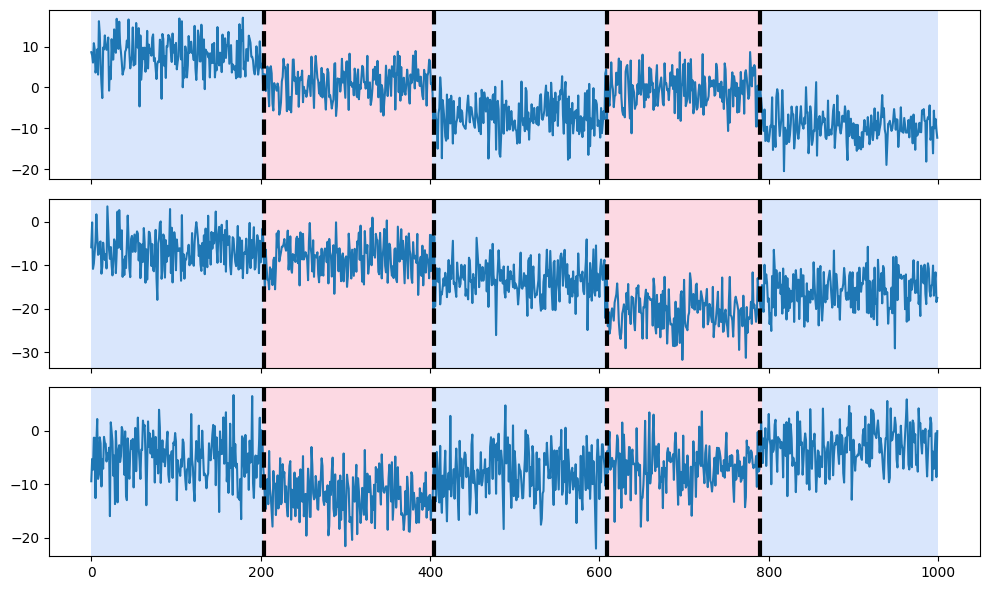

In [ ]:
# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)

# display
rpt.display(signal, bkps, result)
plt.show()

In [ ]:
algo = rpt.Pelt(model="rbf").fit(y[start:end])
result = algo.predict(pen=10)
rpt.display(y[start:end], result)
plt.show()

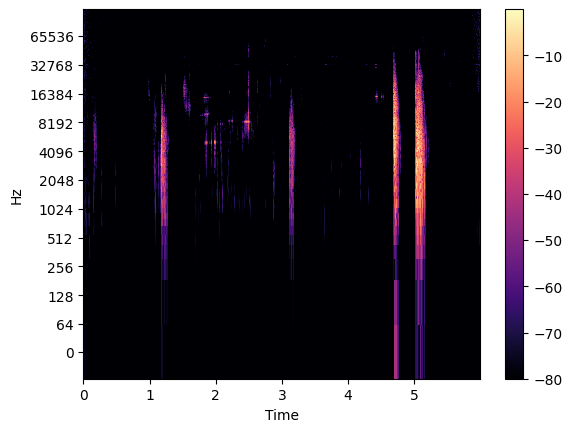

In [ ]:


reduced_noise = nr.reduce_noise(y=y[start:end],  sr=25000)
reduced_noise
reduced_slice, phase = librosa.magphase(librosa.stft(reduced_noise))

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(reduced_slice, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

## Positioning


In [ ]:
from sympy import *

def triangulation(m_x1,m_y1,m_z1,
                  m_x2,m_y2,m_z2,
                  m_x3,m_y3,m_z3,
                  z,speed,delay1,delay2):
                      x = Symbol('x')
                      y = Symbol('y')
                      t = Symbol('t')

                      solved_values = solve([sqrt(pow(m_x1-x,2) + pow(m_y1-y,2)+pow(m_z1-z,2))-(t+delay1)*speed,
                                             sqrt(pow(m_x2-x,2) + pow(m_y2-y,2)+pow(m_z2-z,2))-(t+delay2)*speed,
                                             sqrt(pow(m_x3-x,2) + pow(m_y3-y,2)+pow(m_z3-z,2))-(t)*speed],[x,y,t])
                      return solved_values




In [ ]:
triangulation(5,12,3,
              1,5.34,3,
              9,5.34,3,
              1,5,1,1.5)

[(12.7352335762095, 6.85864192668478, 0.900183162924698)]

This below Section is dedicated to data exploration and understanding

In [ ]:
#utkarsh's work
# from here I will try to continue my work

import pandas as pd



In [ ]:
pip install librosa matplotlib


In [ ]:
import numpy as np

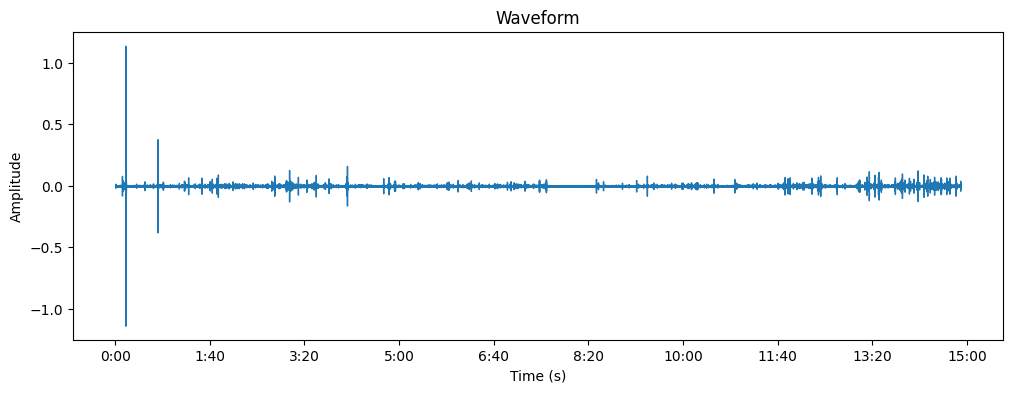

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

# Load audio file using librosa
audio_file = "/content/2023-09-19 ch1.wav"
y, sr = librosa.load(audio_file)

# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


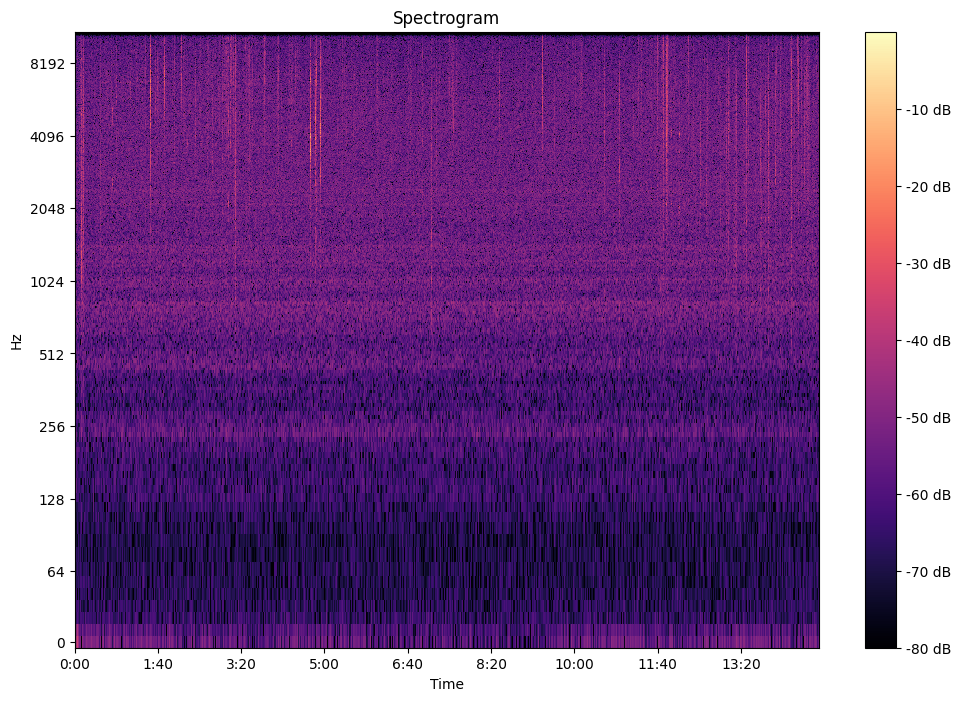

In [ ]:
import librosa.display

# Calculate the spectrogram using librosa
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()


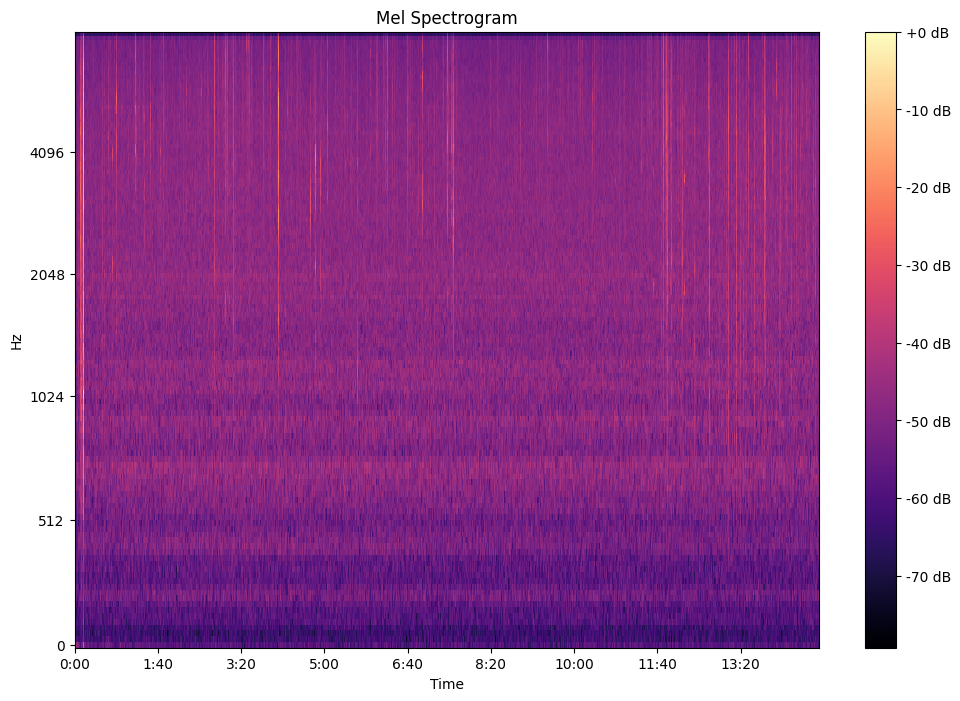

In [ ]:
import librosa.display

# Calculate the Mel spectrogram using librosa
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Plot the Mel spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


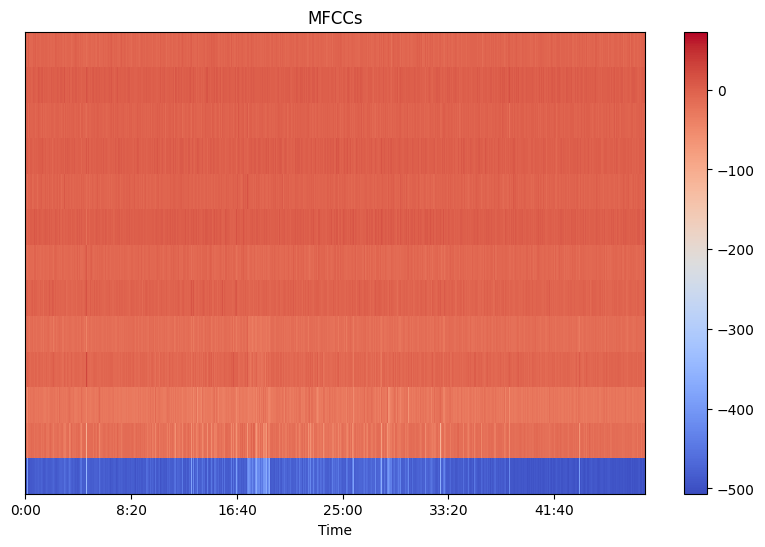

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load audio file using librosa
audio_file = "/content/2023-09-19 ch1.wav"
y, sr = librosa.load(audio_file)

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Visualize MFCCs
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.show()


In [ ]:
#Here I did Beat / Tempo analysis-
import librosa


audio_file = "/content/2023-09-19 ch1.wav"
y, sr = librosa.load(audio_file)


tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

print(f'Tempo: {tempo} BPM')


Tempo: 129.19921875 BPM


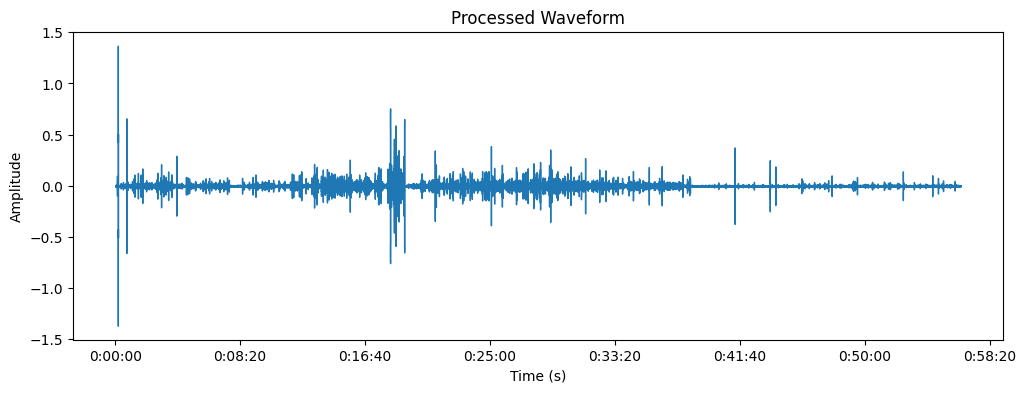

In [ ]:
from librosa.effects import preemphasis, trim

# Apply pre-emphasis (optional, for speech signals)
y = preemphasis(y)

# Trim silent sections (optional)
y, _ = trim(y)

# Apply noise reduction techniques (such as spectral subtraction or Wiener filtering)
# ...

# Visualize the processed waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Processed Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
pip install librosa noisereduce


In [ ]:
pip install pydsm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.6/552.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pydsm: filename=pydsm-0.14.0.0-cp310-cp310-linux_x86_64.whl size=809232 sha256=e58729d4d1ae21854acda91efba535d4da96ded3deefef80500f1e662a4895bd
  Stored in directory: /root/.cache/pip/wheels/05/d9/bf/d407050d7f16ae0d20a168f3dca2432bb63eabe6796346a9c9
Successfully built pydsm


In [ ]:
import librosa
from pydsm import DSM

# Load the audio file
audio_file_path = "/content/2023-09-19 ch1.wav"
audio_data, sr = librosa.load(audio_file_path, sr=None)


# Create DSM instance
dsm = DSM()

# Perform noise reduction
reduced_noise = dsm.process(audio_data, sr)

# Save the processed audio to a new file
output_file_path = "path/to/save/processed/audio.wav "
librosa.output.write_wav(output_file_path, reduced_noise,sr)


ImportError: ignored

In [ ]:
import librosa

# Load the audio file
audio_file_path = "/content/2023-09-19 ch1.wav"
audio_data, sr = librosa.load(audio_file_path, sr=None)

# Apply noise reduction using spectral subtraction
reduced_noise = librosa.effects.preemphasis(librosa.effects.preemphasis(audio_data))

# Save the processed audio to a new file
output_file_path = "audio.wav"
librosa.output.write_wav(output_file_path, reduced_noise, sr)


AttributeError: ignored

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob
#for reading a bunch of audio files

import librosa
import librosa.display
import IPython.display as ipd
#to play audio data in this notebook

from itertools import cycle
#hust for desigining and all

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [ ]:
audio_file="/content/2023-09-19 ch1.wav"

In [ ]:
ipd.Audio(audio_file[0])

IsADirectoryError: ignored

This below Section is dedicated to data transformations

This below Section is dedicated to model building and analysis

This below Section is dedicated for results and post analysis